In [129]:
import matplotlib.pyplot as plt
import scipy as sp
import scipy.constants as spc
from matplotlib.widgets import Button # , Slider
import threading
import sys
import time
import os
import serial
from scipy import interpolate
from scipy import signal
import matplotlib
from GDD import PicoScope as ps  # module for pico_scope
from GDD import ZabberVoiceCoil as stage # module to operate stage 
import traceback
import logging
from IPython.display import display
%matplotlib notebook


## To Check if there is an error in the code



In [2]:
logging.basicConfig( filename="errors.log",
                     filemode='w',
                     level=logging.DEBUG,
                     format= '%(asctime)s - %(levelname)s - %(message)s',
                   )


## Start communication with stage


In [43]:
s = stage.ZabberVoiceCoil('COM3')


ID OK:@01 0 OK BUSY -- 50419


In [45]:
s.sin(1000,100)

b'@01 0 OK BUSY -- 0\r\n'
b'@01 0 OK BUSY -- 0\r\n'


In [55]:
s.sin_stop()


b'@01 0 OK BUSY NI 0\r\n'


In [56]:
s.close()

Communication closed...


In [144]:
ser = serial.Serial('COM3', 115200 , timeout=1, parity=serial.PARITY_NONE)

ser.write(('/home\r\n').encode('utf-8'))
qry = ser.readline()
print(qry)
time.sleep(3)

pos1 = 5.5 # mm
pos2 = 6.5 # mm
vel1 = 20 # mm/s
vel2 = 40 # mm/s
accel = 800 # mm/s^2

stepsize = 2e-4
vel_factor = 8192
accel_facror = 1.220703125

# set current
ser.write(('/set driver.current.run 7\r\n').encode('utf-8'))
qry = ser.readline()
print(qry)

# set acceleration
ser.write(('/set accel {:.0f}\r\n'.format(accel * accel_facror)).encode('utf-8'))
qry = ser.readline()
print(qry)



# set periodic movement using triggers
ser.write(('/trigger 1 when 1 pos == {:.0f}\r\n'.format(pos1/stepsize)).encode('utf-8'))
qry = ser.readline()
ser.write(('/trigger 2 when 1 pos == {:.0f}\r\n'.format(pos2/stepsize)).encode('utf-8'))
qry = ser.readline()
ser.write(('/trigger 1 action a 1 move abs {:.0f}\r\n'.format(pos2/stepsize)).encode('utf-8'))
qry = ser.readline()
ser.write(('/trigger 2 action a 1 move abs {:.0f}\r\n'.format(pos1/stepsize)).encode('utf-8'))
qry = ser.readline()
ser.write(('/trigger 1 action b 1 maxspeed = {:.0f}\r\n'.format(vel1*vel_factor)).encode('utf-8'))
qry = ser.readline()
ser.write(('/trigger 2 action b 1 maxspeed = {:.0f}\r\n'.format(vel2*vel_factor)).encode('utf-8'))
qry = ser.readline()
#enable triggers
ser.write(('/trigger 1 enable\r\n').encode('utf-8'))
qry = ser.readline()
ser.write(('/trigger 2 enable\r\n').encode('utf-8'))
qry = ser.readline()

# start movement by moving to the trigger position
ser.write(('/move abs {:.0f}\r\n'.format(pos1/stepsize)).encode('utf-8'))
qry = ser.readline()



ser.close()

b'@01 0 OK BUSY FE 0\r\n'
b'@01 0 OK IDLE FE 0\r\n'
b'@01 0 OK IDLE FE 0\r\n'


In [145]:
ser = serial.Serial('COM3', 115200 , timeout=1, parity=serial.PARITY_NONE)

# stop movement -> disable triggers
ser.write(('/trigger 1 disable\r\n').encode('utf-8'))
qry = ser.readline()
ser.write(('/trigger 2 disable\r\n').encode('utf-8'))
qry = ser.readline()

ser.close()

In [101]:
class ProcessGDD(object): #TODO live class
    """
    Class used for a adding live update to a figure. Run ´%matplotlib notebook´ in jupyter notebook
    for optimal operation of this class. This adds

    Attributes
    ----------
    rp: `object`
        This object is a Oscilloscope object (initially from Red Pitaya, class daq.devices_new.RPdevice()).
    rpplot: `object`
        This object is a fastplot object (class daq.FastPlotNotebook())."""
    
    def __init__(self):
        
        #initialize values
        self.wl_laser = 633e-9
        self.N_FFT = int(2**16)

        self.z_range = 1e-3
        self.z = sp.linspace(-self.z_range/2, self.z_range/2,self.N_FFT )
        self.dt = (self.z.max() - self.z.min())/(len(self.z)-1) / spc.c 
        self.freq = sp.fftpack.fftfreq(self.N_FFT,self.dt)
        self.wl = spc.c / self.freq
        self.omega = 2 * sp.pi * self.freq
        self.d_omega = self.omega[1] - self.omega[0]
        self.phase_swap = sp.repeat([-1,1],self.N_FFT/2)

        self.GDD_avg = sp.zeros(self.N_FFT)
        self.GDD_scan = sp.zeros(self.N_FFT)
        self.GDD_std = sp.zeros(self.N_FFT)

        self.GDD_avg_pos = sp.zeros(self.N_FFT)
        self.GDD_avg_neg = sp.zeros(self.N_FFT)

        self.i_avg = 0;
        self.i_avg_pos = 0
        self.i_avg_neg = 0
        self.vel1 = 20
        self.vel2 = 40
        self.scan_distance = 1e-3
        self.N = int(1e6)
        R = int(1.0e6)
        D_time = 1/R
        T = self.N/R
        self.timeS = sp.linspace(0,1,self.N)
        self.signal_HeNe = sp.zeros(self.N)
        self.signal_SC = sp.zeros(self.N)
        self.wl_laser = 633e-9  #in m
        
    ###############################################
        self.N_test =int(self.N/500)
        self.time_plot = self.timeS[::self.N_test]
        self.HeNe_plot = sp.zeros_like(self.time_plot)
        self.SC_plot = sp.zeros_like(self.time_plot)
        
    ##################################################    
        
        self.ps = ps.DAQ_parallel_channels(Samples_per_channel= self.N)
    
        self.phase_smp = sp.zeros(self.N_FFT)
        

        self.phase_avg_d2 = sp.zeros_like(self.freq)
        self.GDD_avg = sp.zeros(self.N_FFT)
        
        self.spectra_avg = sp.zeros(self.N_FFT)

    def clear(self):
        self.i_avg = 0
        self.phase_avg_d2 = sp.zeros_like(self.freq)
        self.GDD_avg = sp.zeros_like(self.freq)
        self.spectra_avg = sp.zeros_like(self.freq)
        self.phase_smp = sp.zeros_like(self.freq)
        
        self.HeNe_plot = sp.zeros_like(self.time_plot)
        self.SC_plot = sp.zeros_like(self.time_plot)
        
    def update_data(self, skip_reading_data = False, alignment = False):
        if skip_reading_data == False:
            self.timeS,data = self.ps.DAQ_read()
            self.timeS *= 1e-9
#             data = sp.load('2mm_scan_v1_20_v2_40_acc_800_cur_7.npy')
#             self.timeS = data[:,0] *1e-9
            self.signal_HeNe = data[:,0]
            self.signal_SC = data[:,1]
        
        
#         self.timeS = timeS
#         self.signal_HeNe = signal_HeNe
#         self.signal_SC = signal_SC

        D_time = (self.timeS.max() - self.timeS.min())/ (len(self.timeS)-1)
        
        ## ###################################################new change
        
        self.time_plot = self.timeS[::self.N_test]
        self.HeNe_plot = sp.zeros_like(self.time_plot)
        for i in sp.arange(0, len(self.time_plot)-1, 2):
            self.HeNe_plot[i]=self.signal_HeNe[(i*self.N_test):(i*self.N_test+2*self.N_test)].max()
        for i in sp.arange(1, len(self.time_plot), 2):
            self.HeNe_plot[i]=self.signal_HeNe[(i*self.N_test):(i*self.N_test+2*self.N_test)].min()
        self.HeNe_plot *= 1e-3
        
        self.SC_plot = sp.zeros_like(self.time_plot)
        for i in sp.arange(0, len(self.time_plot)-1, 2):
            self.SC_plot[i]=self.signal_SC[(i*self.N_test):(i*self.N_test+2*self.N_test)].max()
        for i in sp.arange(1, len(self.time_plot), 2):
            self.SC_plot[i]=self.signal_SC[(i*self.N_test):(i*self.N_test+2*self.N_test)].min()
        self.SC_plot *=1e-3
        #####################################################    
#         plt.figure()
#         plt.plot(self.time_plot,self.HeNe_plot)
#         plt.plot(self.time_plot,self.SC_plot)
        #####################################################
        self.signal_HeNe=(self.signal_HeNe-self.signal_HeNe.mean())/(sp.absolute(self.signal_HeNe-self.signal_HeNe.mean())).max() #normalize and shift around zero
        self.signal_SC=(self.signal_SC-self.signal_SC.mean())/(sp.absolute(self.signal_SC-self.signal_SC.mean())).max()
        
        self.signal_HeNe[sp.where(self.signal_HeNe==0)]=sys.float_info.epsilon#1e-100 #works with sign even if smaller than epsilon
        zero_crossings = sp.append(0,sp.absolute(sp.diff(sp.sign(self.signal_HeNe)))) > 0#the [] is important to only get the indizes back
        inds_z = sp.where(zero_crossings)[0]
        #####################################################
#         plt.figure()
#         plt.plot(self.timeS[::500],self.signal_HeNe[::500])
#         plt.plot(self.timeS[::500],self.signal_SC[::500])
        #####################################################
        time_z = self.timeS[inds_z]
        pos = sp.arange(0,len(inds_z))*self.wl_laser/4 * 1e3
        vel = sp.append(0,sp.diff(pos)/sp.diff(time_z))
    
        kern_win_size = 501  # it was 2001 
        x_kern = sp.linspace(-6,6,kern_win_size)
        kern = sp.exp(-x_kern**2/4)
        kern /= kern.sum() # equivalent to kern = kern/kern.sum()
        
        vel_filt = sp.convolve(vel, kern, mode='same') #gaussian filter
        speed_threshold = vel_filt.max() * 0.3 # threshold at 5% of speed
        speed_win = vel_filt > speed_threshold

        win_diff = sp.append(0,sp.diff(sp.array(speed_win,'int')))
        start_ind_z = sp.where(win_diff > 0)[0][1:-1]
        stop_ind_z = sp.where(win_diff < 0)[0][1:-1]


        if start_ind_z[0] > stop_ind_z[0]:
            stop_ind_z = stop_ind_z[1:]

        if start_ind_z[-1] > stop_ind_z[-1]:
            start_ind_z = start_ind_z[:-1]

        if len(start_ind_z) != len(stop_ind_z):
            print('start_ind and stop_ind not the same length.')

        # separate scans
        vel_thresh = (self.vel1 + self.vel2) /2
        ind_start = []
        ind_stop = []
        scan_direction = []

        pos_scan_plot = sp.zeros_like(time_z)
        neg_scan_plot = sp.zeros_like(time_z)
    
        for i in range(len(start_ind_z)):
            win_time_span = time_z[stop_ind_z[i]] - time_z[start_ind_z[i]]
            z_span = pos[stop_ind_z[i]] - pos[start_ind_z[i]]
            if z_span < self.scan_distance*0.9:
                continue        
            win_max_vel = vel_filt[start_ind_z[i]:stop_ind_z[i]].max()
            print('i processed : {}, time win : {:0.3f}, z win : {:.3f}mm, vel {:.3f}mm/s'\
                  .format(i,win_time_span,z_span,win_max_vel))
            ind_start.append(inds_z[start_ind_z[i]])
            ind_stop.append(inds_z[stop_ind_z[i]])
            if win_max_vel > vel_thresh:
                scan_direction.append(-1)
                pos_scan_plot[start_ind_z[i]:stop_ind_z[i]] = 1
            else:
                scan_direction.append(1)
                neg_scan_plot[start_ind_z[i]:stop_ind_z[i]] = 1
        
        
        self.GDD_scan = sp.zeros(self.N_FFT)
        for i in range(len(start_ind_z)):
            time_win = self.timeS[ind_start[i]:ind_stop[i]]
            signal_HeNe_win = self.signal_HeNe[ind_start[i]:ind_stop[i]]
            signal_SC_win = self.signal_SC[ind_start[i]:ind_stop[i]]

            intz = sp.where(sp.absolute(sp.diff(sp.sign(signal_HeNe_win))))[0]
            #solve issue if end of array problem
            if intz[-1]==(len(time_win)-1):
                intz=intz[:-1]
            #linear interpolated zero
            time0s = time_win[intz]+signal_HeNe_win[intz]*D_time/(signal_HeNe_win[intz]-signal_HeNe_win[intz+1])
            position_0s = sp.arange(0,len(time0s))*self.wl_laser/2
            
            z_scanned = position_0s.max() - position_0s.min()
#             print('z_range = {:0.3f}'.format(z_scanned*1e3))
            if z_scanned < self.z_range:
                continue

            f = interpolate.interp1d(time0s,position_0s)
            mask = (time_win > time0s.min()) & (time_win < time0s.max())
            time_win_valid = time_win[mask]
            pos_interp = f(time_win_valid)
            pos_interp = (pos_interp - (pos_interp.max() - pos_interp.min())/2) * scan_direction[i]

            # interpolate the SC data into z
            f_interp_SC = interpolate.interp1d(pos_interp, signal_SC_win[mask])
            signal_SC_win_interpalated = f_interp_SC(self.z)
            
            
            spect_smp = sp.fft(signal_SC_win_interpalated) * self.phase_swap
            spectra = sp.absolute(spect_smp)/sp.absolute(spect_smp).max()
            
            self.spectra_avg = (self.spectra_avg*self.i_avg + sp.absolute(spectra))/(self.i_avg+1)
            
            self.phase_smp = sp.angle(spect_smp)
            self.phase_smp = sp.unwrap(self.phase_smp)
            self.GDD_smp = sp.append(sp.append(0,sp.diff(self.phase_smp,2)),0)/self.d_omega**2 

#             self.phase_avg_d2 = (self.phase_avg_d2*i+sp.convolve(self.GDD_smp, sp.ones(1)/1, mode='same'))/(i+1)
            
            self.GDD_scan = (self.GDD_scan*i + self.GDD_smp)/(i+1)
            self.GDD_avg = (self.GDD_avg*self.i_avg + self.GDD_smp)/(self.i_avg+1)
        
            self.GDD_std = sp.sqrt(1/(self.i_avg+1)*(self.GDD_std**2*(self.i_avg)+(self.GDD_smp-self.GDD_avg)**2))#is not the standard 
                                                #definition since for each step the final avg is not known.
    # separate positive and negative scan direction - just for testing
            if scan_direction[i] > 0:
                self.GDD_avg_pos = (self.GDD_avg_pos*self.i_avg_pos+sp.convolve(self.GDD_smp, sp.ones(3)/3, mode='same'))/(self.i_avg_pos+1)
                self.i_avg_pos +=1
            else:
                self.GDD_avg_neg = (self.GDD_avg_neg*self.i_avg_neg+sp.convolve(self.GDD_smp, sp.ones(3)/3, mode='same'))/(self.i_avg_neg+1)
                self.i_avg_neg +=1
            
            self.i_avg = self.i_avg+1
            
        
    def save_data(self, fn):
        
        wl_mask = (self.wl > 950e-9) * (self.wl < 1150e-9) 
        data = sp.transpose([self.wl[wl_mask], self.spectra_avg[wl_mask], self.GDD_avg[wl_mask]])
        sp.savetxt(fn,data ,header='wl (nm), spectrum (a.u.), gdd (fs^2)',\
                  delimiter=', ' , newline='\r\n')
        
    
    def close(self):
        self.ps.DAQ_close()
       
        # TODO close daq
        

In [123]:
class FastPlotNotebook(object):
   
    def __init__(self,p):
        %matplotlib notebook
        self.p = p
        self.i = 0
        fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(30/2.54,10/2.54))
        self.fig = fig
        self.ax1 = ax1
        self.ax2 = ax2
        self.ax3 = ax3
        self.ax2_phase = ax2.twinx()
        
        self.ax1.set_title('HeNe, IR')
        self.ax2.set_title('Spectrum, phase')
        self.ax3.set_title('GDD')
        
        self.ax1.set_xlim(0,1)
        self.ax1.set_ylim(-0.2,10)
        self.ax1.set_xlabel('Time (s)')
        self.ax1.set_ylabel('Signal (a.u.)')
#         self.ax2.set_xlim(950,1150)
        self.ax2.set_ylim(0,1.1)
        self.ax2.set_xlabel('Wavelength (nm)')
        self.ax2.set_ylabel('Spectrum (a.u.)')
        self.ax2_phase.set_ylabel('Phase (rad)')
        self.ax2_phase.set_ylim(-1e2,1e2)
#         self.ax3.set_xlim(950,1150)
        self.ax3.set_ylim(-1500,1500)
        self.ax3.set_xlabel('Wavelength (nm)')
        self.ax3.set_ylabel('GDD (fs^2)')
        
        
#         timeS = self.p.timeS
#         signal_HeNe = self.p.signal_HeNe
#         signal_SC = self.p.signal_SC
        #####################################################
        timeS = self.p.time_plot
        signal_HeNe = self.p.HeNe_plot
        signal_SC = self.p.SC_plot
        
        #####################################################
        wl = self.p.wl
        self.wl_pl_sel = (wl > 1020e-9)*(wl < 1120e-9)
        wl = wl[self.wl_pl_sel]
        phase_smp = self.p.phase_smp[self.wl_pl_sel]
        spectra_avg = self.p.spectra_avg[self.wl_pl_sel]
        GDD_avg = self.p.GDD_avg[self.wl_pl_sel]
        GDD_scan = self.p.GDD_scan[self.wl_pl_sel]
        
        ind = sp.where(wl < 1070e-9)[0][0]
        phase_smp -= phase_smp[ind]
        spectra_avg /= spectra_avg.max()
        
          
        self.HeNe_pl, = self.ax1.plot(timeS,signal_HeNe)
        self.SC_pl, = self.ax1.plot(timeS,signal_SC)
        self.spect_pl, = self.ax2.plot(wl*1e9,spectra_avg,'b')
        self.phase_pl, = self.ax2_phase.plot(wl*1e9,phase_smp,'r')
        self.gdd_pl, = self.ax3.plot(wl*1e9, GDD_avg * 1e30, 'r',lw=1)
        self.gdd_scan_pl, = self.ax3.plot(wl*1e9, GDD_scan * 1e30, 'g',lw=1)
        
        self.fig.tight_layout()
        self.fig.subplots_adjust(wspace = 0.7,bottom = 0.2)
    
    def update_plot(self):
        self.i +=1
        self.ax1.set_title('HeNe, IR:{}'.format(self.i))
        timeS = self.p.time_plot
        signal_HeNe = self.p.HeNe_plot
        signal_SC = self.p.SC_plot
        wl = self.p.wl
        wl = wl[self.wl_pl_sel]
        phase_smp = self.p.phase_smp[self.wl_pl_sel]
        spectra_avg = self.p.spectra_avg[self.wl_pl_sel]
        
        # gaussian filter
        kern_win_size = 21  # it was 2001 
        x_kern = sp.linspace(-6,6,kern_win_size)
        kern = sp.exp(-x_kern**2/4)
        kern /= kern.sum() # equivalent to kern = kern/kern.sum()
        
        GDD_avg = sp.convolve(self.p.GDD_avg,kern,'same')[self.wl_pl_sel]
        GDD_scan = sp.convolve(self.p.GDD_scan,kern,'same')[self.wl_pl_sel]
        
        ind = sp.where(wl < 1070e-9)[0][0]
        phase_smp -= phase_smp[ind]
        spectra_avg /= spectra_avg.max()
        
        #self.HeNe_pl.set_data(timeS,signal_HeNe)
        self.HeNe_pl.set_ydata(signal_HeNe)
        self.SC_pl.set_ydata(signal_SC)
        self.spect_pl.set_ydata(spectra_avg)
        self.phase_pl.set_ydata(phase_smp)
        self.gdd_pl.set_ydata(GDD_avg * 1e30)
        self.gdd_scan_pl.set_ydata(GDD_scan * 1e30)
        self.fig.canvas.draw()

   

In [124]:
class LiveOsci(object): #TODO live class
   
    def __init__(self):  #(self#,pico_scope,plot_obj)
        self.process_inst = ProcessGDD()
        self.plot_obj = FastPlotNotebook(self.process_inst)
        global loopBool
        loopBool = False
        self.getbuttons()
    
    def getbuttons(self):
        axcolor = 'lightblue'
        ttax = plt.axes([0.05, 0.01, 0.15, 0.06])
        self.buttontt = Button(ttax, 'Single sweep', color=axcolor, hovercolor='0.975')
        self.buttontt.on_clicked(self._update_trace)
        
        runax = plt.axes([0.35, 0.01, 0.05, 0.06])
        self.buttonrun = Button(runax, 'Run', color=axcolor, hovercolor='0.975')
        self.buttonrun.on_clicked(self._looping_pre) #the run command has to be started throgh a thread with a global condition in order to interupt it
        
        stopax = plt.axes([0.425, 0.01, 0.05, 0.06])
        self.buttonstop = Button(stopax, 'Stop', color=axcolor, hovercolor='0.975')
        self.buttonstop.on_clicked(self._stop_meas)
        
        clearax = plt.axes([0.525, 0.01, 0.05, 0.06])
        self.buttonclear = Button(clearax, 'clear', color=axcolor, hovercolor='0.975')
        self.buttonclear.on_clicked(self._clear_button)
        
        saveax = plt.axes([0.725, 0.01, 0.15, 0.06])
        self.buttonsave = Button(saveax, 'Save data', color=axcolor, hovercolor='0.975')
        self.buttonsave.on_clicked(self._save_data)
        
        
        # TODO buttons for clear and save
        
    def _looping_pre(self, event): #this is new
        global loopBool
        if (loopBool == False): #this is needed to prevent problems when the runbutton is started twice
            thread=threading.Thread(target=self._run_meas,args=(event,))
            thread.daemon=True   #might or might not be needed
            thread.start()

    # *********** Button callbacks ********************
    def _run_meas(self,event):
        global loopBool
        loopBool = True
        try:
            while loopBool:
                self.process_inst.update_data()
                self.plot_obj.update_plot()
        except Exception as e:
            logging.exception(e, exc_info=True)
        
    def _update_trace(self,event):
        self.process_inst.update_data()
        self.plot_obj.update_plot()
        
    def _stop_meas(self, event):
        global loopBool
        loopBool = False
        
    def _clear_button(self, event):
        global loopBool
        loopBool = False
        self.process_inst.clear()
        self.plot_obj.update_plot()
        
    def _save_data(self, event):
        global loopBool
        loopBool = False
        try:
            self.process_inst.save_data('test_file.txt')
        except Exception as e:
            logging.exception(e, exc_info=True)

D:\winpython\python\WinPython-64bit-3.5.2.3\python-3.5.2.amd64\lib\site-packages\ipykernel\__main__.py:23: RuntimeWarning: divide by zero encountered in true_divide


<IPython.core.display.Javascript object>


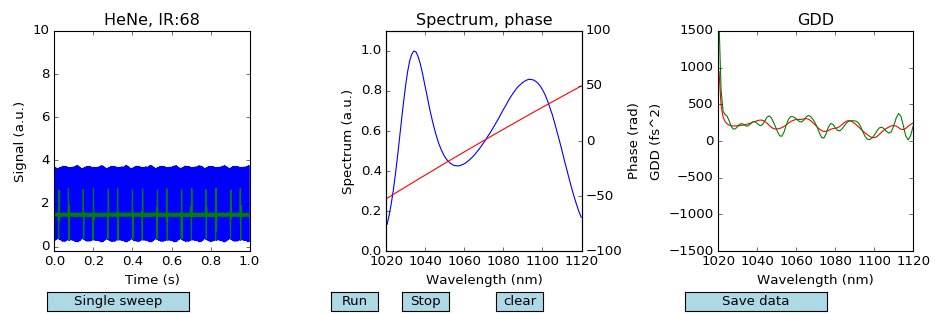

D:\winpython\python\WinPython-64bit-3.5.2.3\python-3.5.2.amd64\lib\site-packages\ipykernel\__main__.py:53: RuntimeWarning: invalid value encountered in true_divide


In [127]:

liveplt = LiveOsci() #rp,rpplot


In [146]:
liveplt.process_inst.close()

In [70]:
liveplt.process_inst.update_data(skip_reading_data=False)

PicoSDKCtypesError: PicoSDK returned 'PICO_INVALID_HANDLE'

<IPython.core.display.Javascript object>


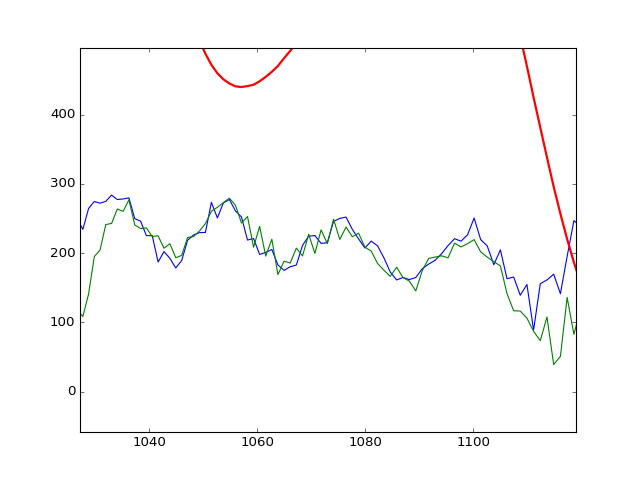

(-1000, 1000)

In [119]:
plt.figure()
pl_mask = (liveplt.process_inst.wl > 1020e-9) * (liveplt.process_inst.wl < 1120e-9)
plt.plot(liveplt.process_inst.wl[pl_mask]*1e9,sp.convolve(liveplt.process_inst.GDD_avg_pos, sp.ones(9)/9, mode='same')[pl_mask]*1e30)
plt.plot(liveplt.process_inst.wl[pl_mask]*1e9,sp.convolve(liveplt.process_inst.GDD_avg_neg, sp.ones(9)/9, mode='same')[pl_mask]*1e30)
# plt.plot(wl[pl_mask]*1e9,sp.convolve(GDD_avg, sp.ones(9)/9, mode='same')[pl_mask]*1e30,'r')
plt.plot(liveplt.process_inst.wl[pl_mask]*1e9, liveplt.process_inst.spectra_avg[pl_mask] *1000,lw=2)

plt.ylim(-1000,1000)


In [53]:
# timeS = liveplt.process_inst.timeS
# signal_HeNe = liveplt.process_inst.signal_HeNe
# signal_SC = liveplt.process_inst.signal_SC




In [54]:
# data = sp.transpose([timeS,signal_HeNe,signal_SC])
# sp.save('data_causing_error1.npy',data)